# Validation: Heldout Data Example

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* holds-out the final few days of the data, and see's if they can be predicted. 

The way I propose doing this is holding out the confirmed observations for the final three days of the day for every country, and then plotting it for validation. This effectively changes the output model. 

Compared to the above changes, lets make the following changes:

* Switch the prior to the ICL prior used. 
* Refine the country list
* switch to binary interventions
* use active rather than confirmed cases
* transform into log space

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Masks over 60                              0.000 ... 0.016 ... 1.000 ... [0. 1.]
 2 Asymptomatic contact isolation             0.000 ... 0.120 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 10                   0.000 ... 0.153 ... 1.000 ... [0. 1.]
 4 Gatherings limited to 100                  0.000 ... 0.248 ... 1.000 ... [0. 1.]
 5 Gatherings limited to 1000                 0.000 ... 0.285 ... 1.000 ... [0. 1.]
 6 Business suspended - some                  0.000 ... 0.283 ... 1.000 ... [0. 1.]
 7 Business suspended - many                  0.000 ... 0.206 ... 1.000 ... [0. 1.]
 8 Schools and universities closed            0.000 ... 0.359 ... 1.

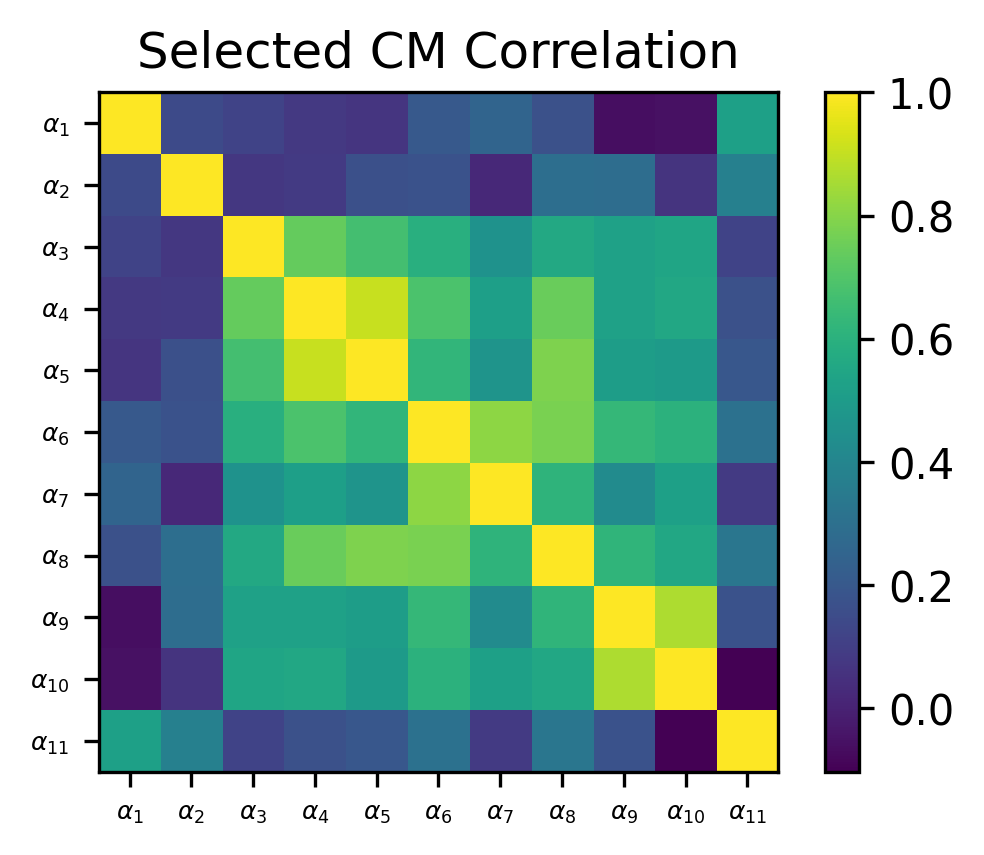

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-15",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 35 Regions: f['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK']


In [9]:
regions = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
# Same, outside Europe
regions += ['AD', 'CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'SG']


features = ['Masks over 60',
 'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew - permissive',
 'General curfew - strict',
 'Healthcare specialisation over 0.2']
feature_labels = ['Ma>60',
                 'Asy Iso',
                 'Gath<10',
                 'Gath<100',
                 'Gath<1000',
                 'Bus Some',
                 'Bus Many',
                 'Sch Clsd',
                 'Curf sm',
                 'Curf strc',
                 'spc>.2']

dp = DataPreprocessor(end_date="2020-04-15")
data = dp.preprocess_data("../../data", regions, features)

In [10]:
with cm_effect.models.CMModelFlexibleV3p1(data) as model:
    model.build_cm_reduction_exp_gamma_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior(pm.Normal, {"mu": 1, "sigma": 0.05})
    model.build_rates()
    model.build_output_model()

/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed_log contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [11]:
#pm.model_to_graphviz(model).render("modelV3.1")
#pm.model_to_graphviz(model)

In [12]:
model.run(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CM_Alpha_log__              -15.61
RegionGrowthRate_log          9.98
RegionNoiseScale             72.69
Growth                     3196.22
InitialSize_log            -112.75
Observed_log_missing          0.00
Observed_log           -8471768.97
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
INFO:pymc3:NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [02:51<00:00,  8.18draws/s]
The acceptance probability does not match the target. It is 0.9385329495848447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8959541686318875, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some par

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out


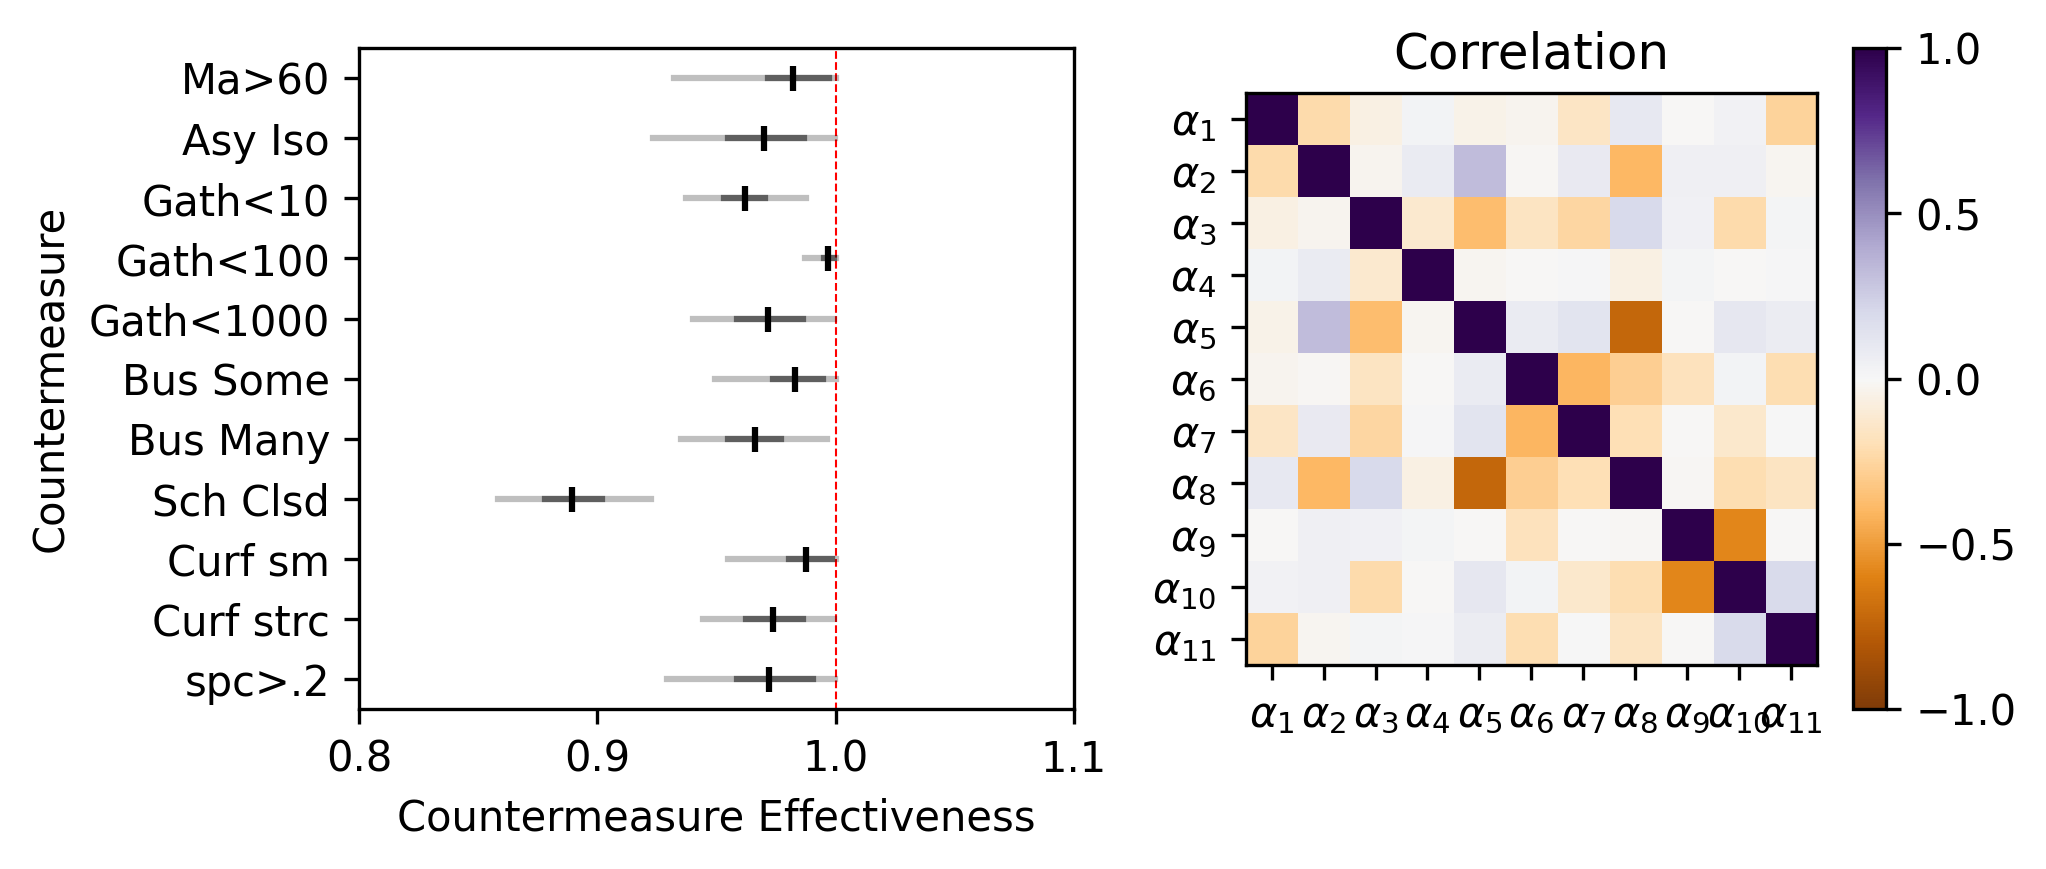

In [13]:
model.plot_effect(x_min=0.8, x_max=1.1, labels=feature_labels)

# Model with Reliability Factor on Growth Rate

In [14]:
with cm_effect.models.CMModelFlexibleV3p1(data) as model2:
    model2.build_cm_reduction_exp_gamma_prior()
    model2.build_region_growth_prior()
    model2.build_region_reliability_prior()
    model2.build_rates()
    model2.build_output_model()

/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed_log contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [15]:
#pm.model_to_graphviz(model2).render("modelV3.2")
#pm.model_to_graphviz(model2)

In [16]:
model2.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CM_Alpha_log__              -15.61
RegionGrowthRate_log          9.98
RegionNoiseScale             72.69
Growth                     3196.22
InitialSize_log            -112.75
Observed_log_missing          0.00
Observed_log           -8471768.97
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
INFO:pymc3:NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
Sampling 2 chains, 0 divergences:  13%|█▎        | 650/5000 [00:59<06:35, 11.00draws/s] 


ValueError: Not enough samples to build a trace.

In [ ]:
model2.plot_traces()

In [ ]:
model2.plot_effect(labels=feature_labels)

# The Region Reliability Metric doesn't seem to make that much difference when applied to the growth noise. Let's instead apply it to the confirmation noise. 

(changed the library to run this next experiment!)

In [17]:
with cm_effect.models.CMModelFlexibleV3p1(data) as model3:
    model3.build_cm_reduction_exp_gamma_prior()
    model3.build_region_growth_prior()
    model3.build_region_reliability_prior()
    model3.build_rates()
    model3.build_output_model()

/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed_log contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [ ]:
#pm.model_to_graphviz(model3).render("modelV3.3")
#pm.model_to_graphviz(model3)

In [18]:
model3.run(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CM_Alpha_log__              -15.61
RegionGrowthRate_log          9.98
RegionNoiseScale             72.69
Growth                     3196.22
InitialSize_log            -112.75
Observed_log_missing          0.00
Observed_log           -8471768.97
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
INFO:pymc3:NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:36<00:00, 14.44draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ac4e0a0>,
      dtype=object)

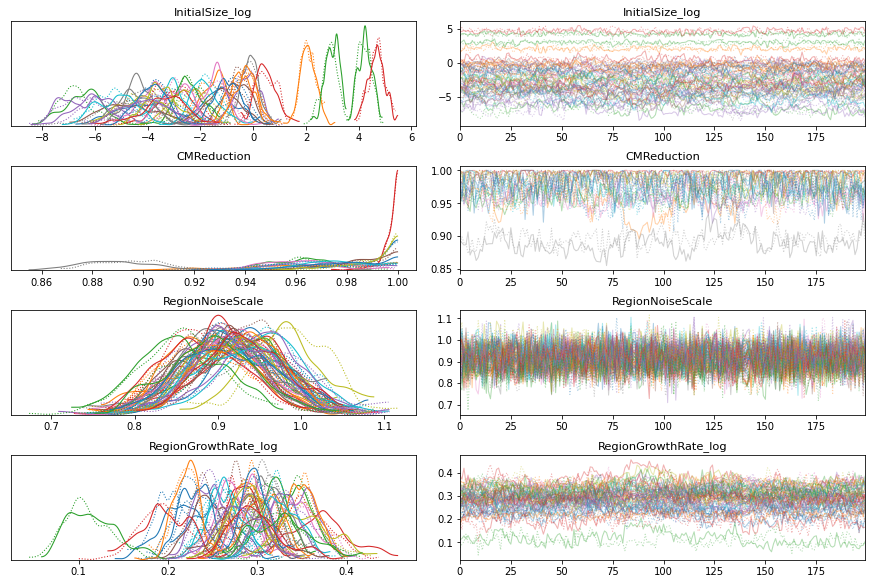

In [19]:
model3.plot_traces()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out


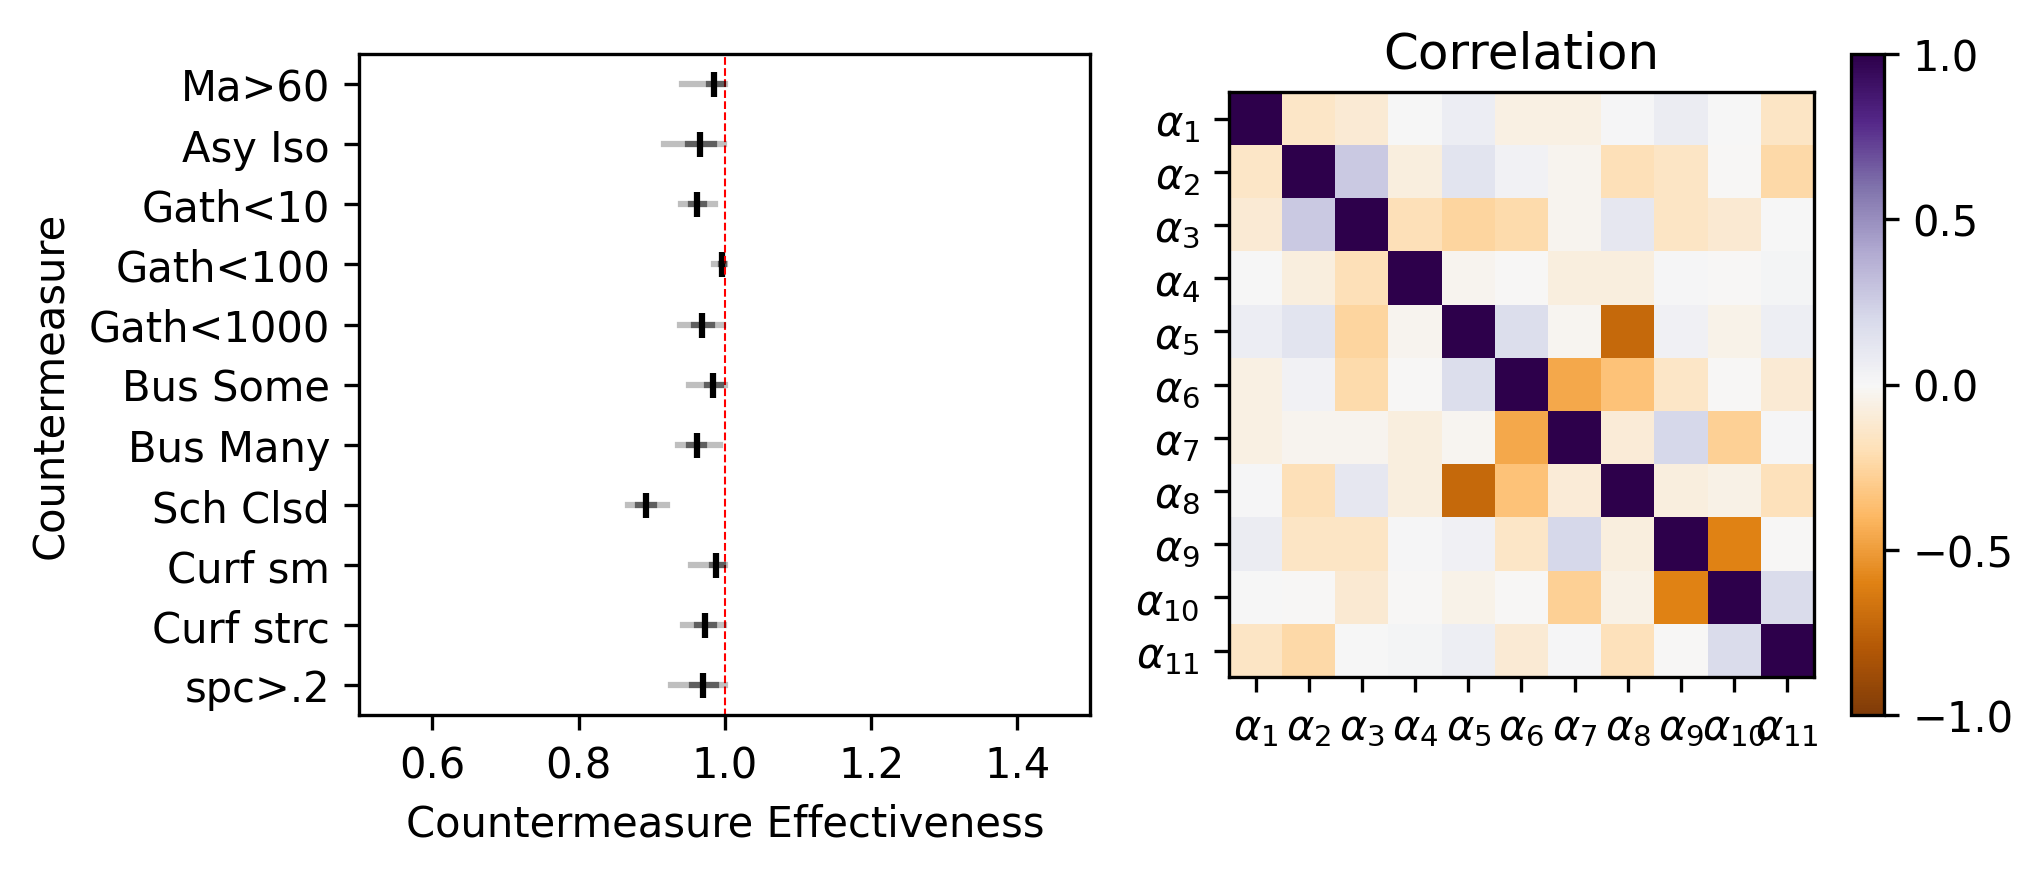

In [33]:
model3.plot_effect(labels=feature_labels)

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out


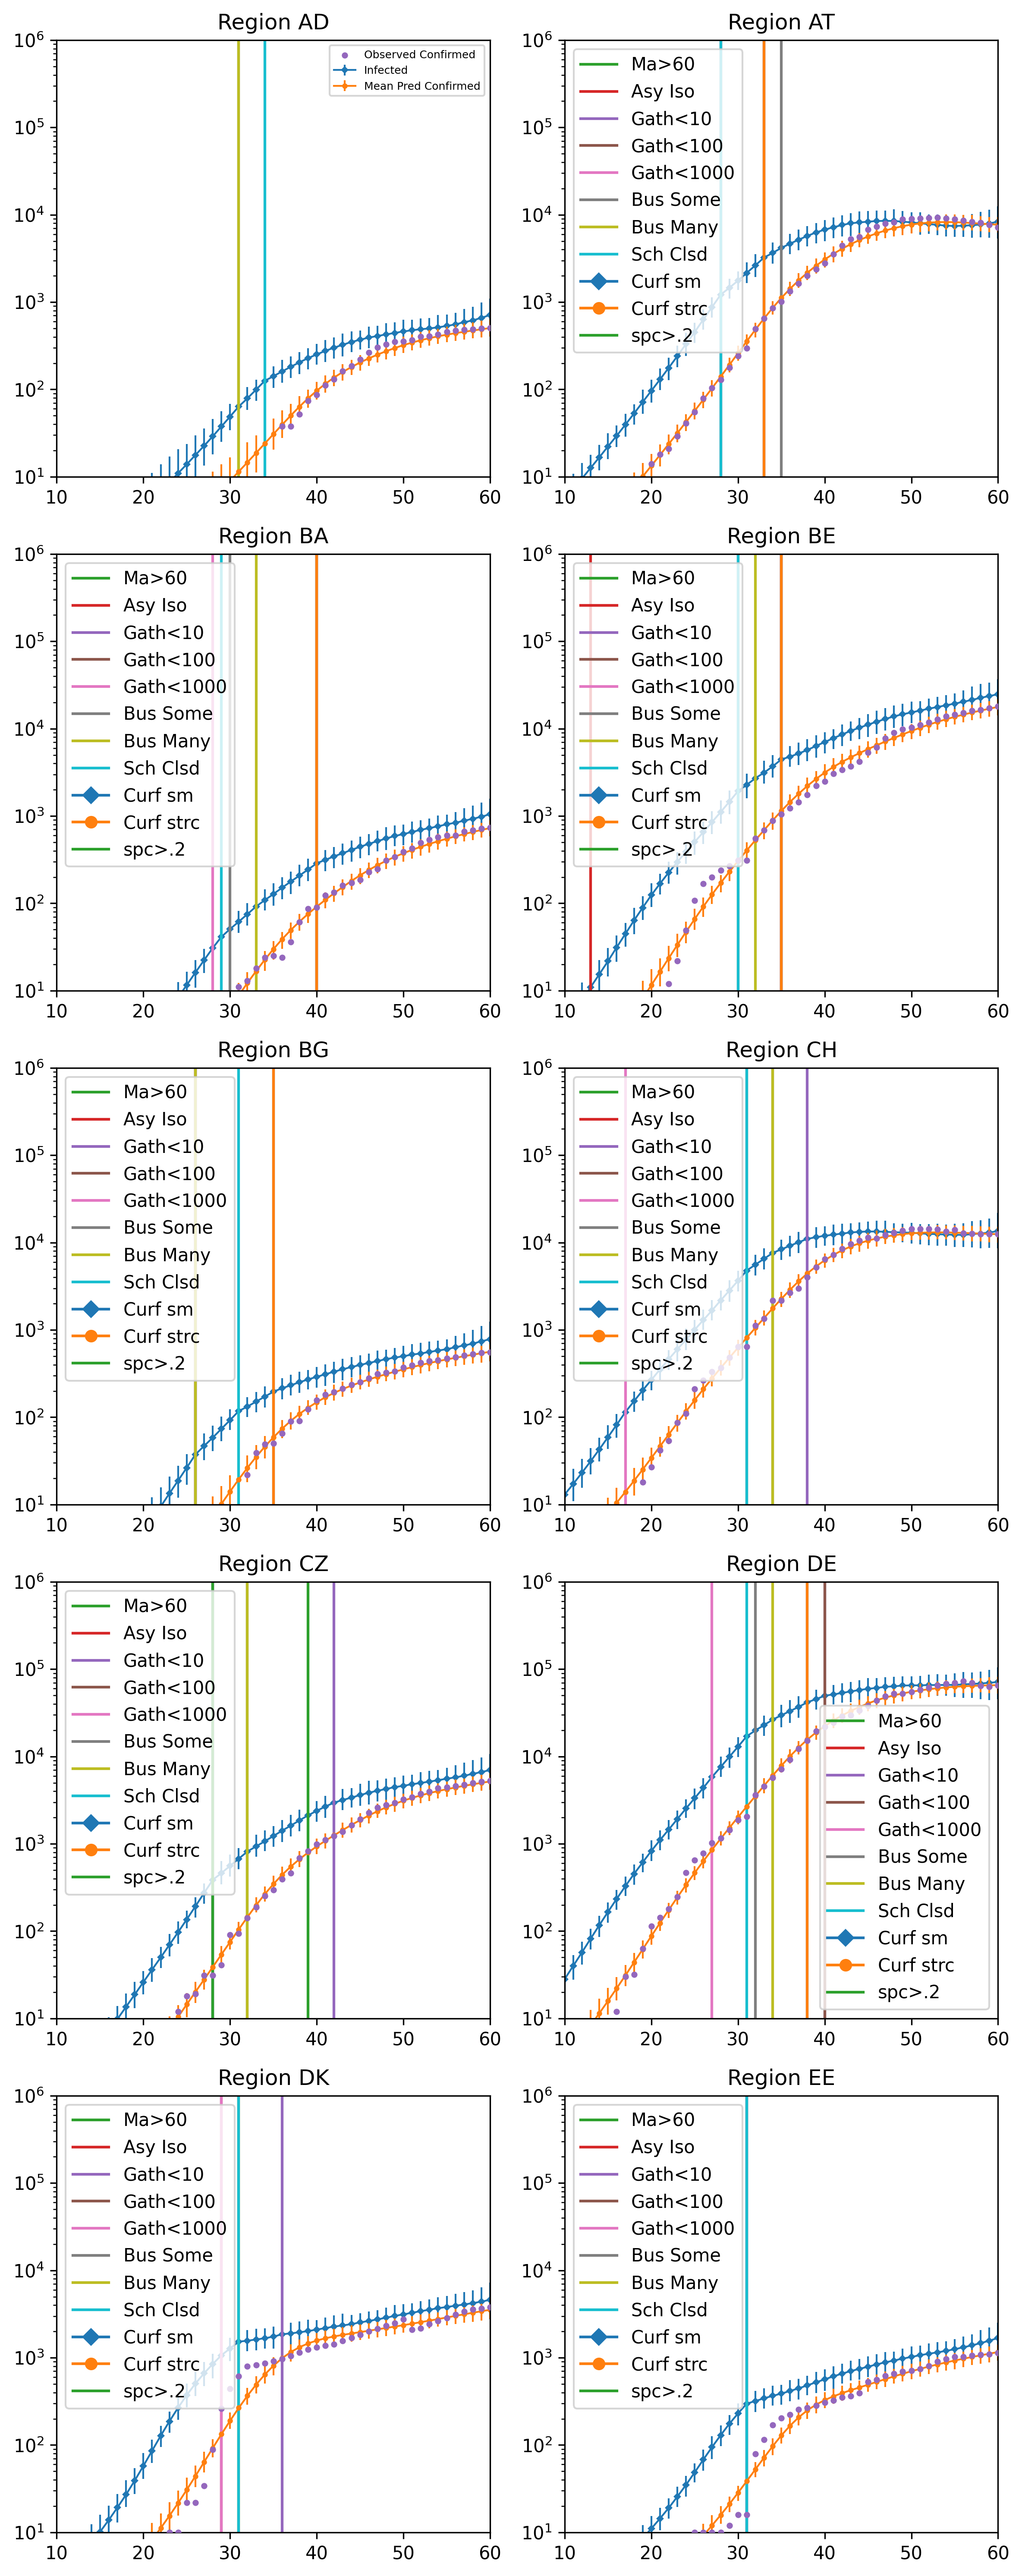

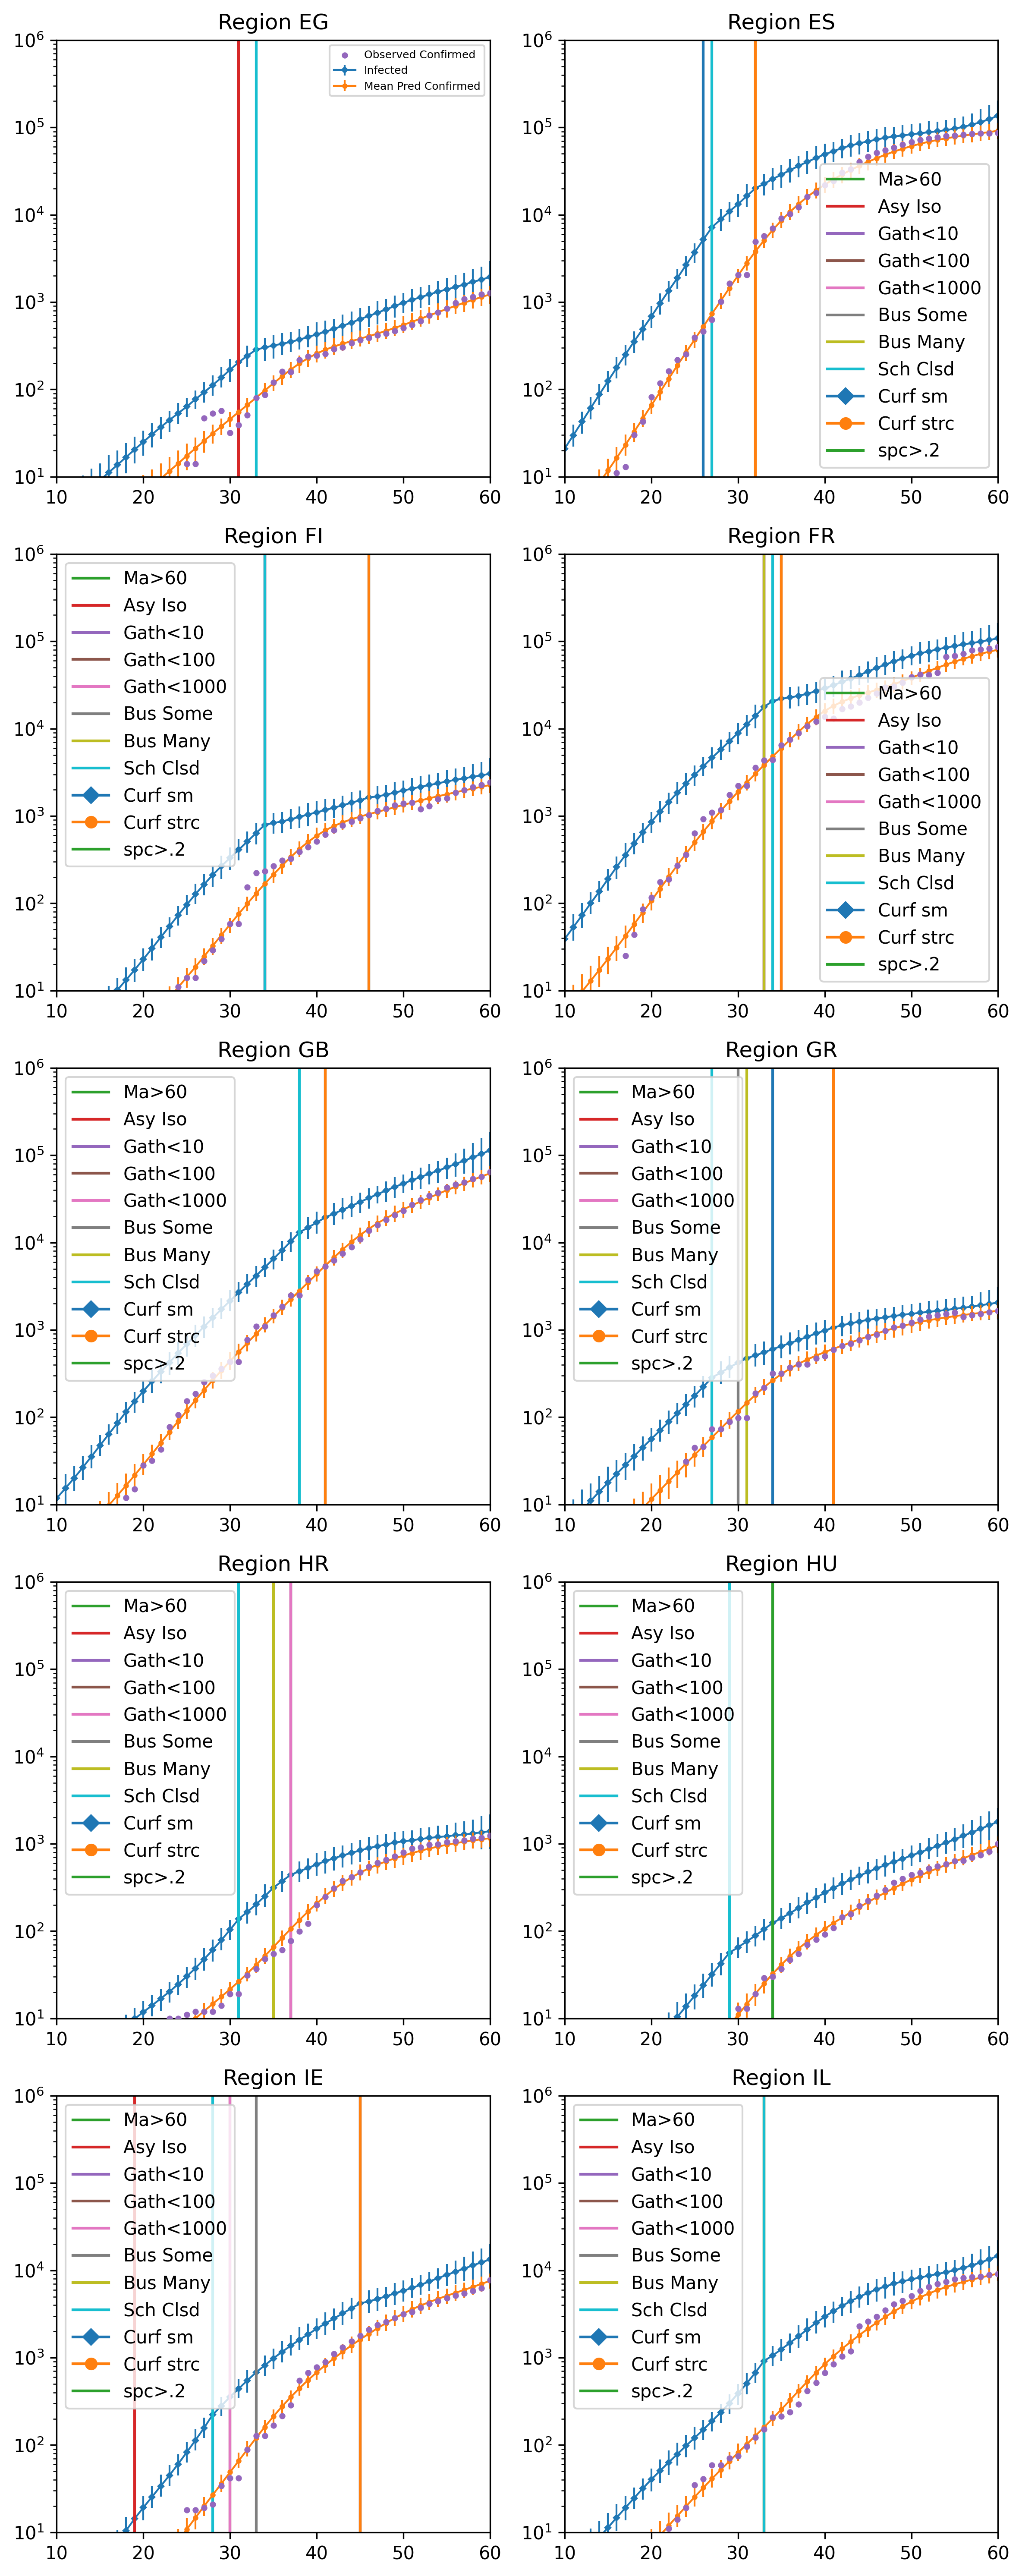

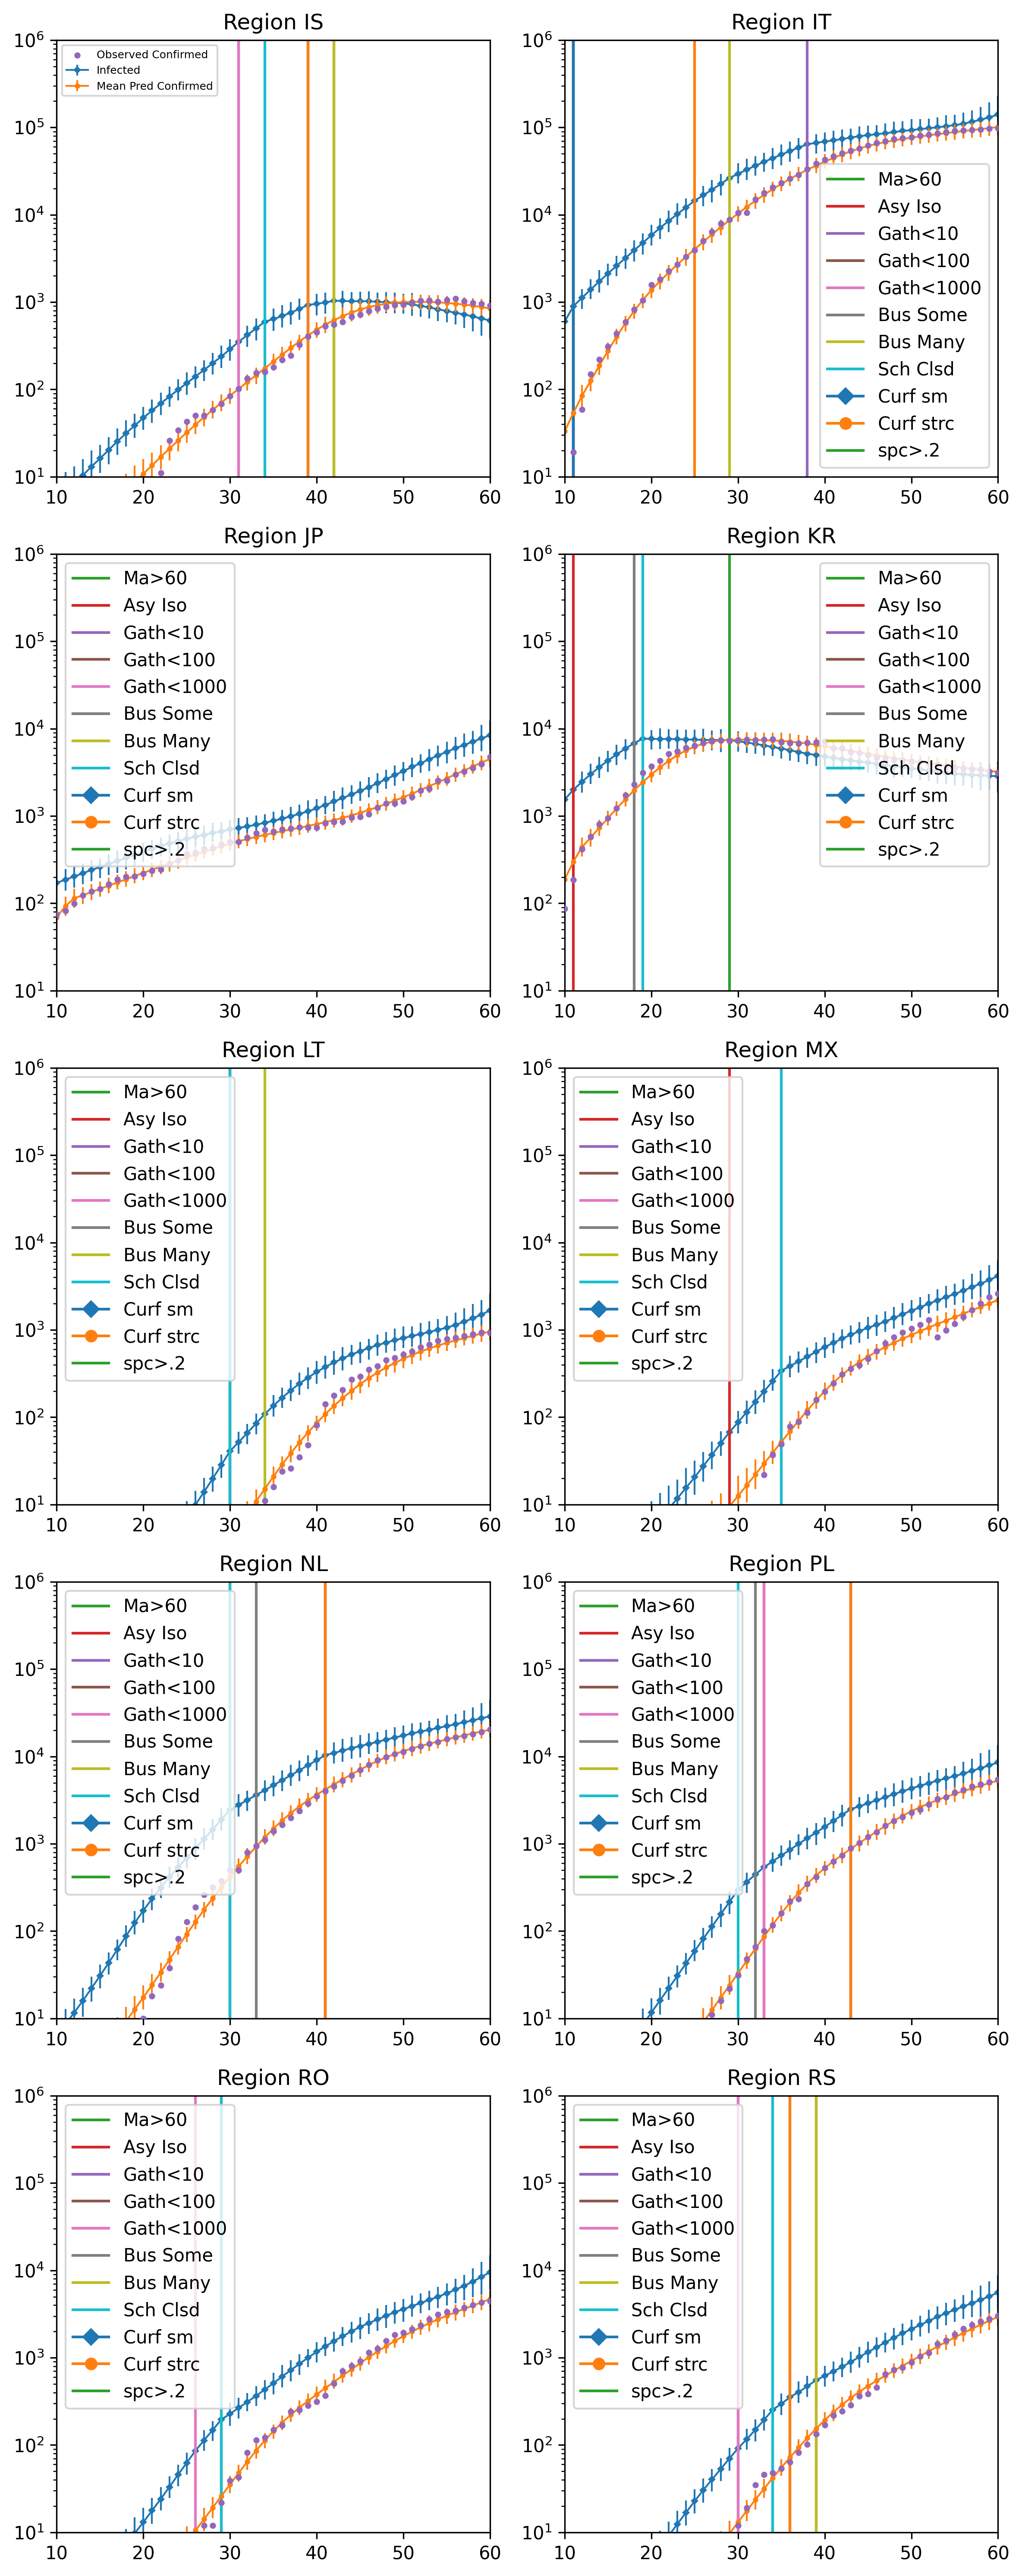

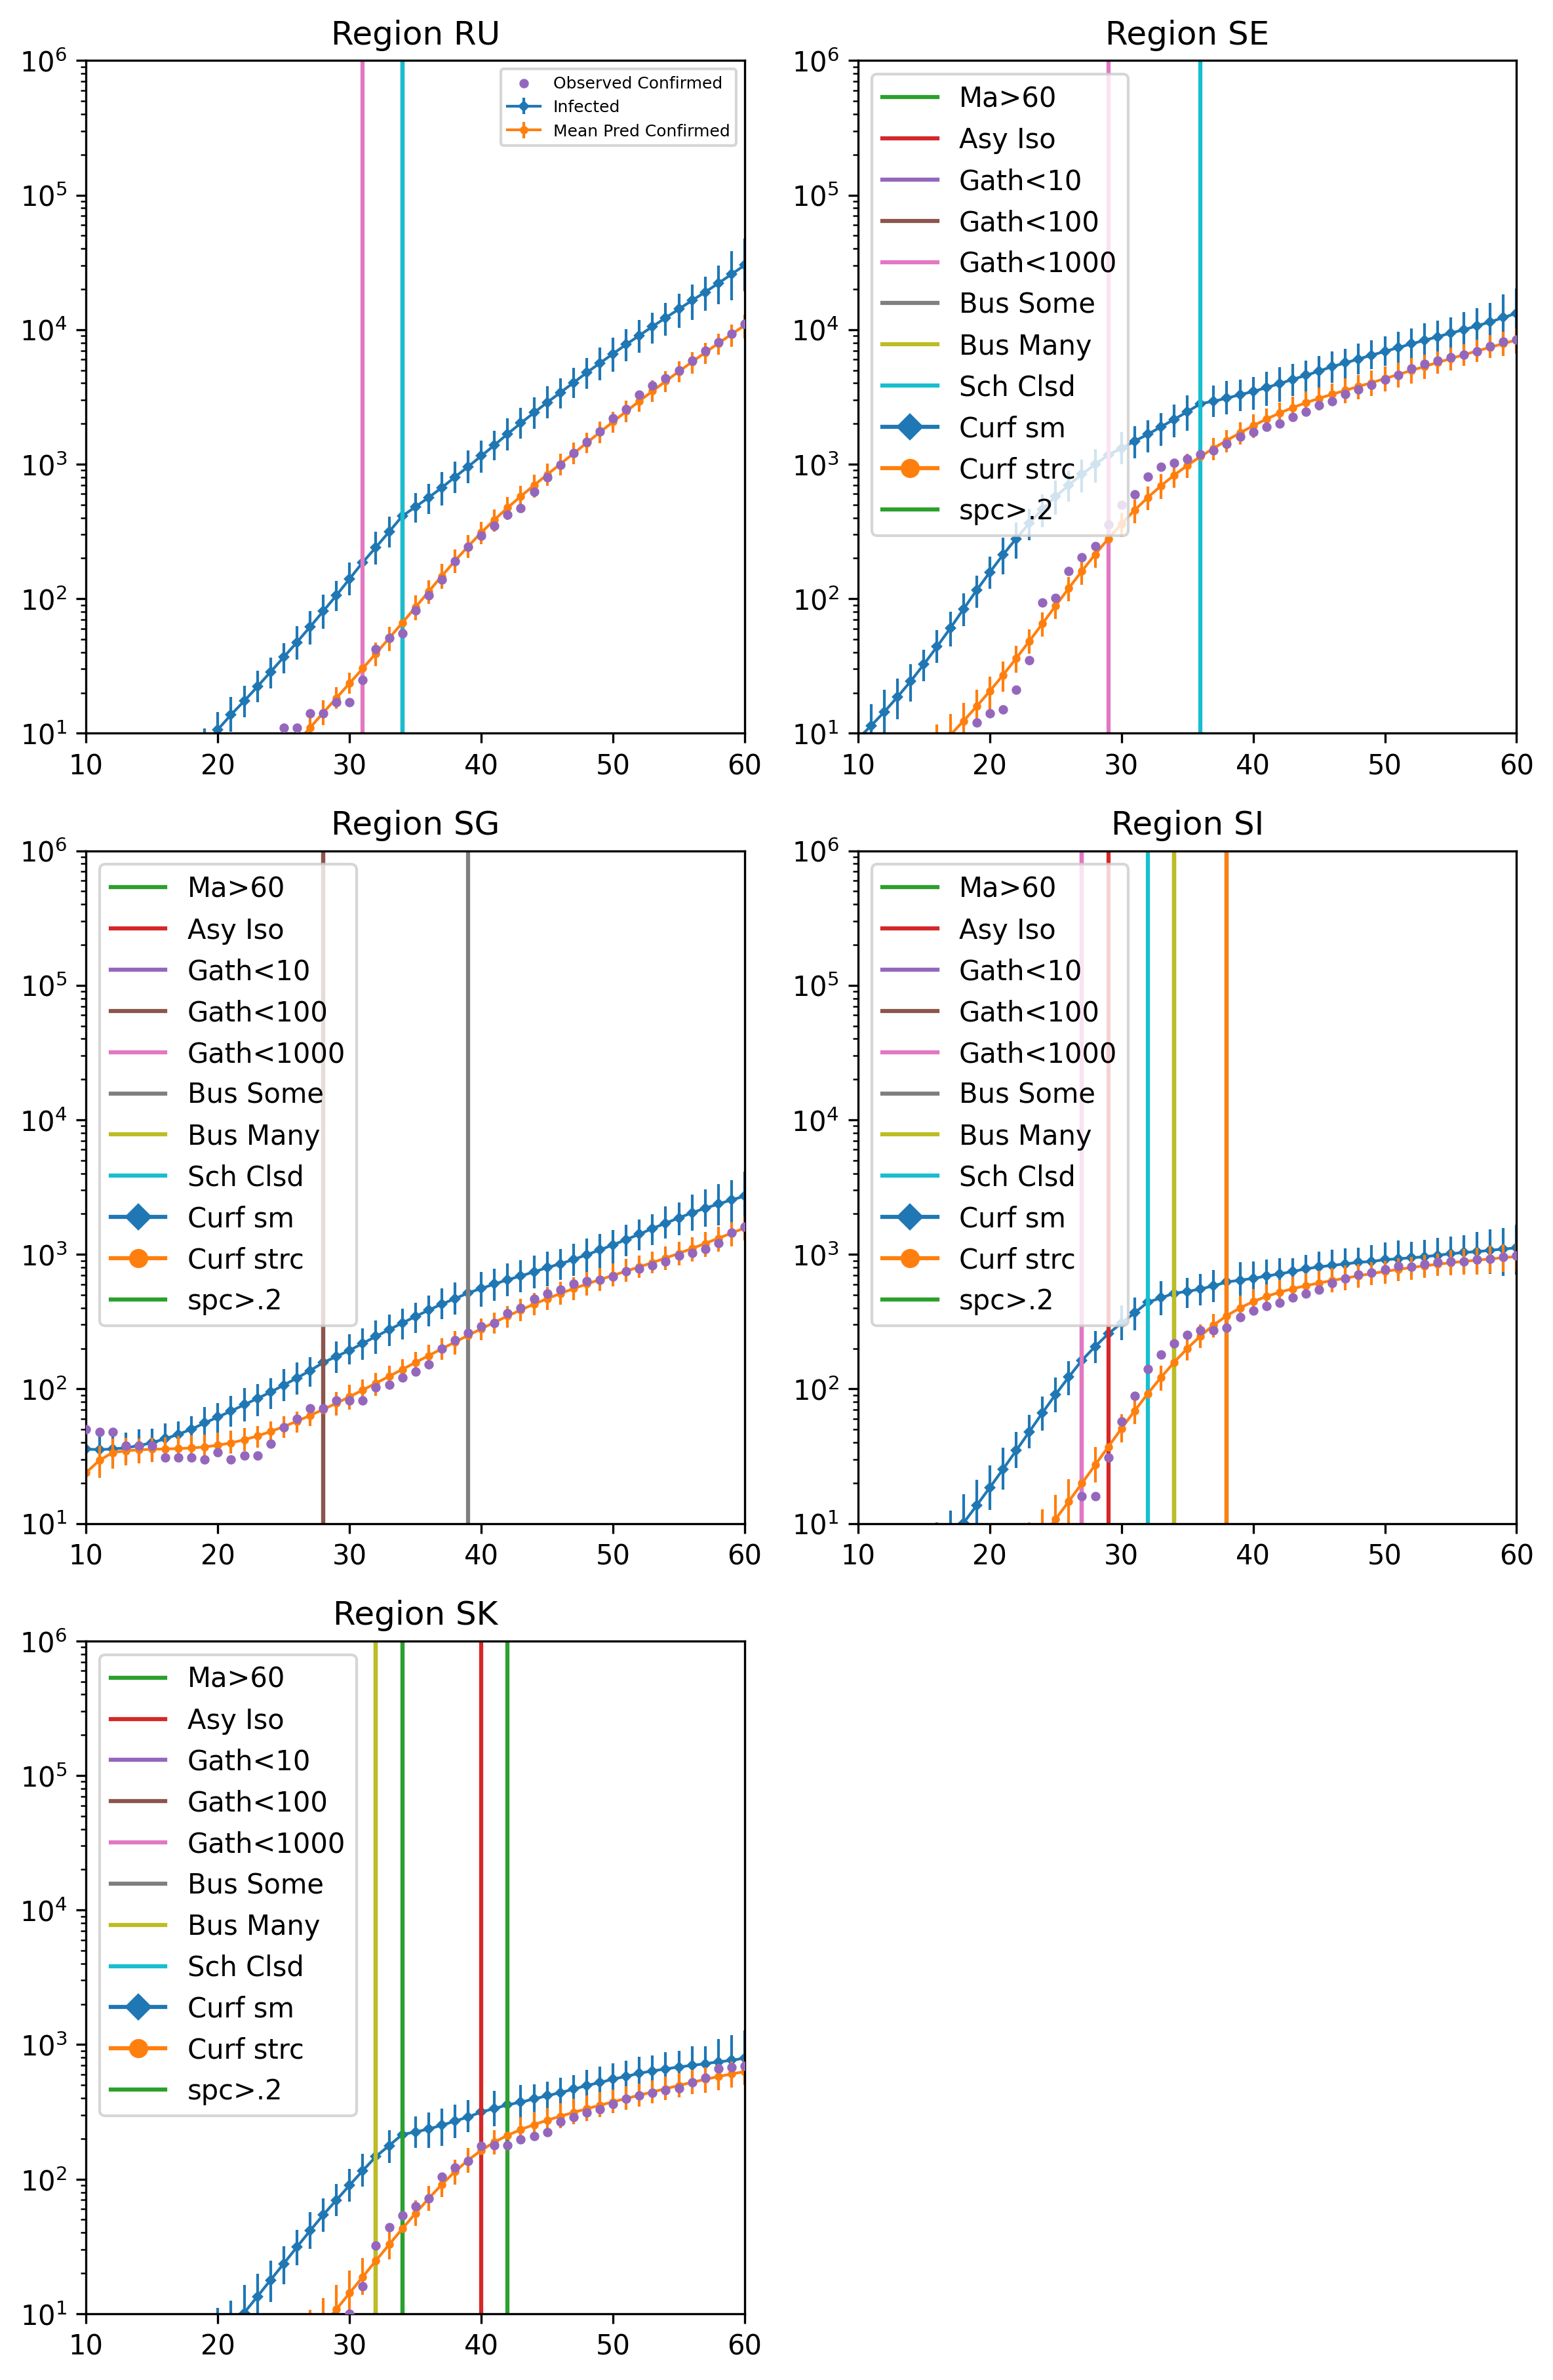

In [38]:
model3.plot_region_predictions(cm_labels=feature_labels)

# Heldout Analysis

In [ ]:
with cm_effect.models.CMModelFlexibleV3p1(data, heldout_days=[63, 64, 65]) as model4:
    model4.build_cm_reduction_exp_gamma_prior()
    model4.build_region_growth_prior()
    model4.build_region_reliability_prior()
    model4.build_rates()
    model4.build_output_model()

In [ ]:
#pm.model_to_graphviz(model4).render("modelV3.3_heldoutdays")
#pm.model_to_graphviz(model4)

In [ ]:
model4.run(2000)

In [ ]:
fig=plt.figure()
plt.step(np.arange(66), data.ActiveCMs[0,:,:].T)

In [ ]:
data.ActiveCMs.shape


In [39]:
data.

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.